# Intro

In this post I will cover several components needed for style GAN and build a basic one using those blocks.  I am not going to train it, or try to make a state of the art one.  Things will be simplified to the simplest form possible to understand the concept.  If you want to understand some of the key techniques used in modern SoTA GANs, this is the post for you!

A future post will be actually building a real StyleGAN model to produce high def images to show practical GANs in full size networks to create actual images.  Reading this post first is highly recommended!

Inspiration for this post came from the [deeplearning.ai](deeplearning.ai) GAN specialization.  For more complete information on GANs in a structured course, check that course out!

# Truncated Noise

The first is an easy one to get us warmed up.  This is not something used during training, but rather a technique you can use after training to control the diversity-quality trade-off when you generate images.

Generators work by taking in random noise.  The random noise can be thought of a a random seed that the generators create images from.  Normally we sample from the normal distribution.  If you look at the normal distribution graph below you will realize that some values will be selected a lot, while others will be selected pretty rarely.  If a value is in the tail, it will be selected much less frequently than a value close to the mean.  So what does that mean?  It means that for those particular values there will have been fewer examples to train with and will thus probably will result in lower quality images.

In order to deal with this issue we can truncate the normal distribution to sample from only the higher frequency areas.  The reason this is a trade-off is because if we have fewer possible values (starting points), that mean means fewer possible images can be generated.  In other words we will have less diverse outputs.  

**So the key things to know are**:

+ Truncated Normal Distribution just cuts off values on each each based on some set parameter
+ Left graph shows normal distribution - right graphs show different levels of truncation
+ There is a diversity/quality trade-off that this technique allows you to make
+ Graphs are most diversity in output images to least diversity from left to right
+ Graphs are lowest quality images to highest quality images from left to right

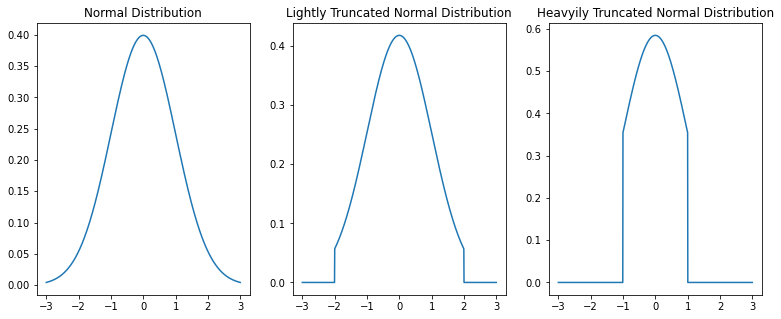

In [ ]:
#| echo: false
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
import torch

x_range = np.linspace(-3,3,1000)
fig,ax = plt.subplots(1,3,figsize=(13,5))
ax[0].plot(x_range, stats.truncnorm.pdf(x_range, -5, 5, loc=0, scale=1))
ax[1].plot(x_range, stats.truncnorm.pdf(x_range, -2, 2, loc=0, scale=1))
ax[2].plot(x_range, stats.truncnorm.pdf(x_range, -1, 1, loc=0, scale=1))
ax[0].set_title('Normal Distribution')
ax[1].set_title('Lightly Truncated Normal Distribution')
ax[2].set_title('Heavyily Truncated Normal Distribution')
plt.show()

In [ ]:
#| include: false
from scipy.stats import truncnorm

def get_truncated_noise(n_samples, z_dim, truncation):
    return torch.Tensor(truncnorm.rvs(-truncation, truncation, size=(n_samples, z_dim)))

# Noise to Weight Mapping

The next component is a noise to weight mapping.  A generator gets a noise vector of random values from the normal distribution.  This may be problematic.  Not all of our features will follow the normal distribution - so trying to map normal distribution values to various features that follow other distributions gets messy.

This is especially problematic because we want to be able to independently control features in the output image.  I don't want to modify the direction the eyes are looking and have that also change facial features.  I want to be able to tweak components without having a tangled mess of mappings.

To fix this we learn the distributions that are ideal for the noise vector.  So random noise comes in, it gets passed through a Mapping Network and we end with a weight matrix `w`.  Since a neural network can approximate any function, that means it can approximate any distribution so this should work.  This lets your model learn represent things in a cleaner way and makes your mapping much less tangled so you can control features much easier.

The mapping network in StyleGAN is composed of 8 layers - but here's a simplified version just to get the idea that it's just a normal neural network that is mapping the noise vector (z) to the weights vector (w).

In [ ]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, hidden_dim, w_dim):
        super().__init__()

        self.mapping = nn.Sequential(
            nn.Linear(z_dim,      hidden_dim),  nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),  nn.ReLU(),
            nn.Linear(hidden_dim, w_dim))

    def forward(self, noise): return self.mapping(noise)
    
MappingNetwork(100,200,75)

MappingNetwork(
  (mapping): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=75, bias=True)
  )
)

# Noise Injection

Next, we need a process for injecting random noise in various parts of the network.  This is different than the weight vector we created above.  We inject this additional noise to increase diversity.  The way this works:

1. Create 1 weight for each channel (learned)
1. Create a noise tensor of random numbers the same size as your image, but with only 1 channel (random)
1. Multiply noise tensor by each of those values so you end with something same dimension as image and add this to the image

That outputs the new image that includes the noise can continue down the network.  Nothing special needs to happen other than this because we didn't change any dimensions.  Really it's just a linear layer with random noise in it.  You can see below that then image shape and the final shape are identical.

This happens in many places in the network before every AdaIN layer.  So let's see what the AdaIN layer is.

In [ ]:
class InjectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(channels)[None, :, None, None])

    def forward(self, image):
        noise_shape = (image.shape[0],1,image.shape[2],image.shape[3]) 
        noise = torch.randn(noise_shape, device=image.device)
        out = image + self.weight * noise
        print(f'Image (input)                     {image.shape}')        
        print(f'Weight (step 1):                  {self.weight.shape}')
        print(f'Noise (step 2):                   {noise.shape}')
        print(f'weight * noise + image (ouput):   {out.shape}')
        return out
tmp = InjectNoise(512)(torch.randn(32,512,4,4))

Image (input)                     torch.Size([32, 512, 4, 4])
Weight (step 1):                  torch.Size([1, 512, 1, 1])
Noise (step 2):                   torch.Size([32, 1, 4, 4])
weight * noise + image (ouput):   torch.Size([32, 512, 4, 4])


# Adaptive Instance Normalization (AdaIN)


To recap what we have so far:

+ An image that has random noise injected into it from the Noise Injection Step
+ A transformed noise matrix from our mapping network `w`

We need to combine these and we need some sort of normalization.  That is what this Adaptive Instance normalization is going to do.  Just like the noise injection happens in many places in the network.

As previously mentioned, injecting `w` rather than just normally distributed noise gives us more control over the images generated.  We are going to take our image after normalization, multiply it by a `scale` from the weight matrix and add a `shift` also from the weight matrix. Put another way, another linear layer.  So in summary what we need to do is:

1. Normalize the image
1. Use a linear layer to map `w` to 1 value per channel to give us a `scale` tensor
1. Use a linear layer to map `w` to 1 value per channel to give us a `shift` tensor
1. output `style_tensor * normalized_image  + shift_tensor`


Take a look below at some the code for what it does and the shapes to understand the inputs and outputs.  Input and output size is the same, but with normalization and injected weight tensor!

In [ ]:
class AdaIN(nn.Module):

    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.scale_transform = nn.Linear(w_dim, channels)
        self.shift_transform = nn.Linear(w_dim, channels)

    def forward(self, image, w):
        normalized_image = self.instance_norm(image)
        scale_tensor = self.scale_transform(w)[:, :, None, None]
        shift_tensor = self.shift_transform(w)[:, :, None, None]
        transformed_image = scale_tensor * normalized_image + shift_tensor
        
        print(f'Image (input)                       {image.shape}')        
        print(f'normalized_image (step 1)           {normalized_image.shape}')        
        print(f'w (input)                           {w.shape}')        
        print(f'scale (step 2):                     {scale_tensor.shape}')
        print(f'shift (step 3):                     {shift_tensor.shape}')
        print(f'scale * norm_image + shift (ouput): {transformed_image.shape}')
        
        return transformed_image
tmp = AdaIN(512,256)(torch.randn(32,512,4,4),torch.randn(32,256))

Image (input)                       torch.Size([32, 512, 4, 4])
normalized_image (step 1)           torch.Size([32, 512, 4, 4])
w (input)                           torch.Size([32, 256])
scale (step 2):                     torch.Size([32, 512, 1, 1])
shift (step 3):                     torch.Size([32, 512, 1, 1])
scale * norm_image + shift (ouput): torch.Size([32, 512, 4, 4])


# Progressive Growing

Now there's one last piece we need to understand the main components of styleGAN.  Progressive growing is just what it sounds like.  The generator will create a small image and progressively grow the size.  It doubles the image in size until getting the image to the required size.  This allows for higher quality and resolution photos.  

Intuitively this makes sense.  It'd be much harder to generate an entire picture all at once that all meshes well together.  Instead we put basic structures and build on it slowly by filling in more and more fine details over time as the image you are generating increases in size.

So let's jump into it.  Let's create a re-usable block to implement this using the other components as well.  Here's what we need:

1. An upsampling layer (for progressive growing)
1. A convolutional layer (standard for image problems)
1. Random noise injection (we created that above)
1. An AdaIN layer (we created that above)
1. An activation (just like all neural networks need)

In [ ]:
class MinifiedStyleGANGeneratorBlock(nn.Module):

    def __init__(self, in_chan, out_chan, w_dim, kernel_size, starting_size, use_upsample=True):
        super().__init__()
        self.use_upsample = use_upsample
        if self.use_upsample: self.upsample = nn.Upsample((starting_size), mode='bilinear')
        self.conv = nn.Conv2d(in_chan, out_chan, kernel_size, padding=1) 
        self.inject_noise = InjectNoise(out_chan)
        self.adain = AdaIN(out_chan, w_dim)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x, w):
        if self.use_upsample: x = self.upsample(x) # upsample        (step 1)
        x = self.conv(x)                           # conv layer      (step 2)
        x = self.inject_noise(x)                   # noise injection (step 3)        
        x = self.activation(x)                     # activation      (step 4)     
        x = self.adain(x, w)                       # AdaIN           (step 5)
        return x


Now, you can implement progressive growing and put it all together.  Let's see how that works in StyleGAN. As you can see we move from an 8x8 image to a 16x16 image.  StyleGAn will do this many times.

Keep in mind all of this is simplified and scaled down from what is in StyleGAN.  The purpose of this blog was to communicate the core concepts and techniques used in StyleGAN, not necessarily show the practical applications.  Stay tuned for a blog that shows practical application of these concepts!

In [ ]:
#| code-fold: true
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.scale_transform = nn.Linear(w_dim, channels)
        self.shift_transform = nn.Linear(w_dim, channels)

    def forward(self, image, w):
        normalized_image = self.instance_norm(image)
        scale_tensor = self.scale_transform(w)[:, :, None, None]
        shift_tensor = self.shift_transform(w)[:, :, None, None]
        transformed_image = scale_tensor * normalized_image + shift_tensor
        return transformed_image
      
class InjectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(channels)[None, :, None, None])

    def forward(self, image):
        noise_shape = (image.shape[0],1,image.shape[2],image.shape[3]) 
        noise = torch.randn(noise_shape, device=image.device)
        out = image + self.weight * noise
        return out

In [ ]:
class MinifiedStyleGANGenerator(nn.Module):

    def __init__(self, z_dim, map_hidden_dim, w_dim, in_chan, out_chan, kernel_size, hidden_chan):
        super().__init__()
        self.map = MappingNetwork(z_dim, map_hidden_dim, w_dim)
        self.sc = nn.Parameter(torch.randn(1, in_chan, 4, 4))
        self.block0 = MinifiedStyleGANGeneratorBlock(in_chan, hidden_chan, w_dim, kernel_size, 4)
        self.block1 = MinifiedStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 8)
        self.block2 = MinifiedStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 16)
        self.block1_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
        self.block2_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)

    def upsample_to_match_size(self, smaller_image, bigger_image):
        return F.interpolate(smaller_image, size=bigger_image.shape[-2:], mode='bilinear')

    def forward(self, noise, return_intermediate=False):
        w = self.map(noise) # This is our mapping network going from noise -> w
        x = self.block0(self.sc, w) # w from mapping network is input here
        
        x1 = self.block1(x, w) # w noise from mapping network is input here also
        image1 = self.block1_to_image(x1)
        print(f'ImageSize1      {image1.shape}')
        
        x2 = self.block2(x1, w) # w noise from mapping network is input here also
        image2 = self.block2_to_image(x2)
        print(f'ImageSize2      {image2.shape}')
        
        x1_upsample = self.upsample_to_match_size(image1, image2)
        return 0.2 * (image2) + 0.8 * (x1_upsample)  
      
tmp = MinifiedStyleGANGenerator(z_dim=128, map_hidden_dim=1024,w_dim=496,in_chan=512,out_chan=3, kernel_size=3, hidden_chan=256)(get_truncated_noise(10, 128, 0.7))

ImageSize1      torch.Size([10, 3, 8, 8])
ImageSize2      torch.Size([10, 3, 16, 16])
